In [26]:
import pandas as pd

splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/fancyzhx/ag_news/" + splits["train"])

In [ ]:
!pip install contractions inflect beautifulsoup4 tqdm -qq

import nltk
import re
import contractions
import inflect
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

# Download necessary NLTK data silently
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True) # Added to fix LookupError

# Initialize global objects for efficiency within the cell
p = inflect.engine()
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Performs a series of text cleaning operations:
    1. Resolves contractions.
    2. Converts to lowercase.
    3. Removes HTML/XML tags.
    4. Converts numbers to words.
    5. Removes punctuation and special characters.
    6. Removes extra whitespaces.
    7. Removes stop words.
    8. Lemmatizes the text.
    9. Stems the text.
    """
    # 1. Resolve contractions
    text = contractions.fix(text)

    # 2. Convert to lowercase
    text = text.lower()

    # 3. Remove HTML/XML tags
    text = BeautifulSoup(text, 'html.parser').get_text()

    # 4. Convert numbers to words
    words = []
    for word in text.split():
        if word.isdigit():
            words.append(p.number_to_words(word))
        else:
            words.append(word)
    text = ' '.join(words)

    # 5. Remove punctuation and special characters (keep only alphanumeric and spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 6. Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize for stop word removal, lemmatization, and stemming
    tokens = nltk.word_tokenize(text)

    # 7. Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]

    # 8. Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    # 9. Stem
    stemmed_tokens = [stemmer.stem(word) for word in lemmatized_tokens]

    return ' '.join(stemmed_tokens)

# Apply the cleaning function to the 'text' column and create a new 'cleaned_text' column
tqdm.pandas(desc="Cleaning Text") # Initialize tqdm for pandas
df['cleaned_text'] = df['text'].progress_apply(clean_text)

# Display the first ten sentences of the newly cleaned dataset
print("First ten sentences of the cleaned dataset:")
print(df['cleaned_text'].head(10).to_string())

Cleaning Text:   0%|          | 0/120000 [00:00<?, ?it/s]

First ten sentences of the cleaned dataset:
0    wall st bear claw back black reuter reuter sho...
1    carlyl look toward commerci aerospac reuter re...
2    oil economi cloud stock outlook reuter reuter ...
3    iraq halt oil export main southern pipelin reu...
4    oil price soar alltim record pose new menac u ...
5    stock end near year low reuter reuter stock en...
6    money fund fell latest week ap ap asset nation...
7    fed minut show dissent inflat usatodaycom usat...
8    safeti net forbescom forbescom earn phd sociol...
9    wall st bear claw back black new york reuter s...


Descriptive statistics for 'text_length' column:
count    120000.000000
mean        165.894767
std          46.616365
min          34.000000
25%         137.000000
50%         163.000000
75%         189.000000
max         769.000000
Name: text_length, dtype: float64


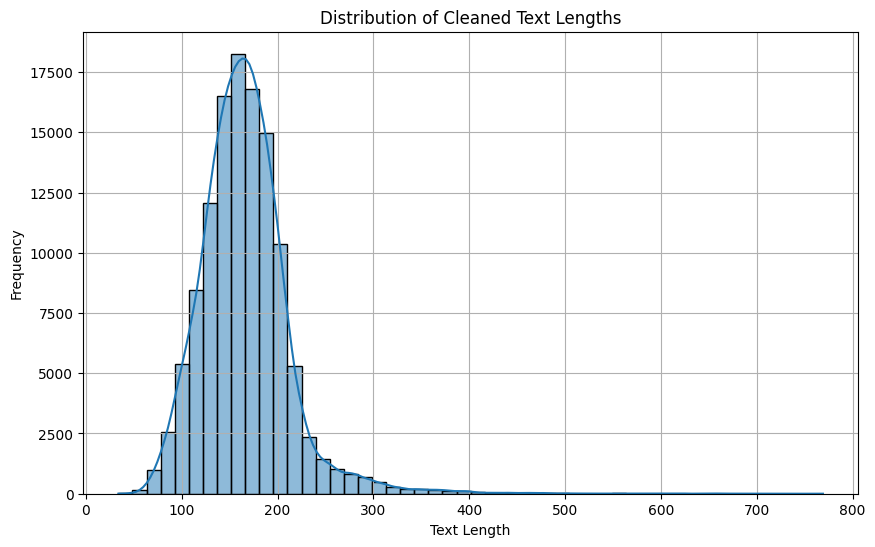

Text length analysis and visualization completed.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate the length of each entry in the 'cleaned_text' column
df['text_length'] = df['cleaned_text'].apply(len)

# 2. Print descriptive statistics for the 'text_length' column
print("Descriptive statistics for 'text_length' column:")
print(df['text_length'].describe())

# 3. Create a histogram of the 'text_length' column
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)

# 4. Add a title to the plot
plt.title('Distribution of Cleaned Text Lengths')

# 5. Label the x-axis and y-axis
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# 6. Display the plot
plt.grid(True)
plt.show()

print("Text length analysis and visualization completed.")

Top 20 most frequent words:
39: 37319
new: 21213
said: 19996
reuter: 17243
two: 16898
ap: 16151
u: 12506
one: 11548
year: 10886
compani: 10050
first: 9044
say: 8721
world: 8628
report: 8122
game: 7692
monday: 7483
wednesday: 7362
tuesday: 7303
oil: 7230
thursday: 7175


/tmp/ipython-input-4282528059.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='viridis')


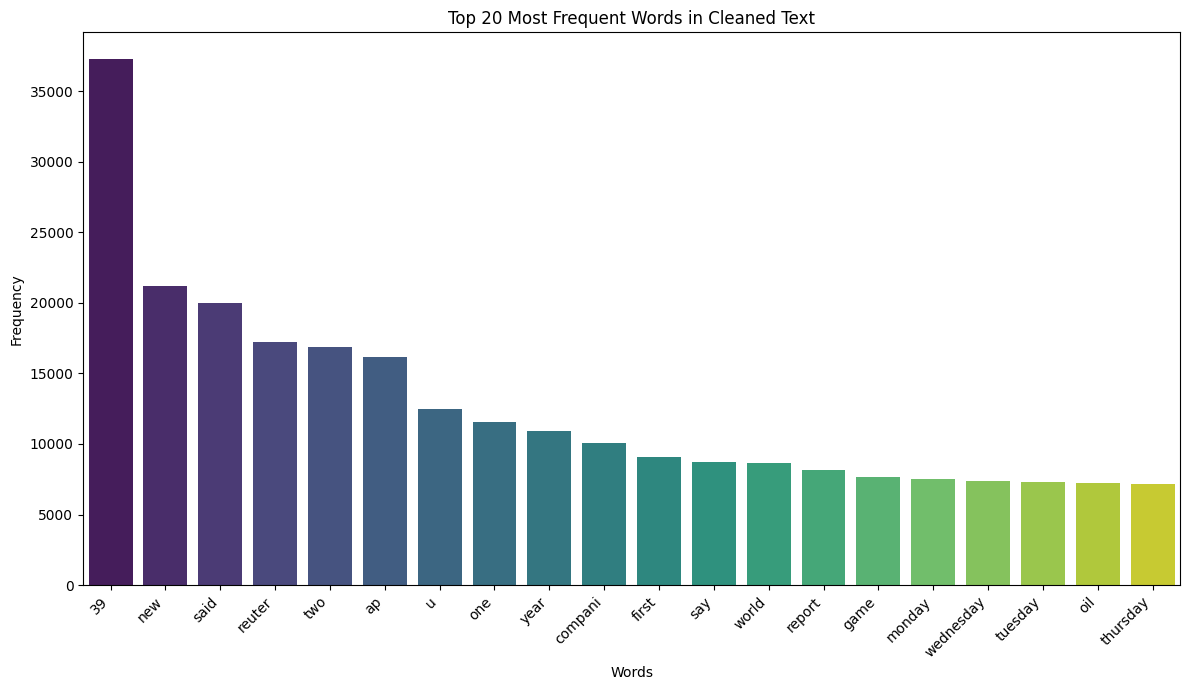

Most frequent words analysis and visualization completed.


In [ ]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Tokenize the 'cleaned_text' column into individual words
# Since 'cleaned_text' is already stemmed and lemmatized, it should be ready for tokenization by splitting on spaces.
all_words = list(itertools.chain.from_iterable(df['cleaned_text'].apply(lambda x: x.split())))

# 2. Count the frequency of each word
word_freq = Counter(all_words)

# 3. Identify the top N most frequent words (e.g., top 20)
top_n = 20
most_common_words = word_freq.most_common(top_n)

print(f"Top {top_n} most frequent words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# 4. Visualize the most frequent words using a bar chart
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 7))
sns.barplot(x=list(words), y=list(counts), palette='viridis')

plt.title(f'Top {top_n} Most Frequent Words in Cleaned Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Most frequent words analysis and visualization completed.")

In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df['cleaned_text']
y = df['label']

# Split the dataset into training and initial testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the initial test set into a new test set and a validation set (10% each of original data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Dataset split into training, validation, and testing sets successfully.")
print(f"Training set size: {len(X_train)} samples")
print(f"Validation set size: {len(X_val)} samples")
print(f"Test set size: {len(X_test)} samples")

Dataset split into training, validation, and testing sets successfully.
Training set size: 96000 samples
Validation set size: 12000 samples
Test set size: 12000 samples


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm.notebook import tqdm

# Initialize CountVectorizer and fit on X_train, then transform all sets
count_vectorizer = CountVectorizer()
print("Fitting and transforming with CountVectorizer...")
X_train_count = count_vectorizer.fit_transform(tqdm(X_train, desc="Count Vectorizing X_train"))
X_val_count = count_vectorizer.transform(tqdm(X_val, desc="Count Vectorizing X_val"))
X_test_count = count_vectorizer.transform(tqdm(X_test, desc="Count Vectorizing X_test"))

print("Count Vectorization completed.")
print(f"Shape of X_train_count: {X_train_count.shape}")
print(f"Shape of X_val_count: {X_val_count.shape}")
print(f"Shape of X_test_count: {X_test_count.shape}")

# Initialize TfidfVectorizer and fit on X_train, then transform all sets
tfidf_vectorizer = TfidfVectorizer()
print("\nFitting and transforming with TF-IDF Vectorizer...")
X_train_tfidf = tfidf_vectorizer.fit_transform(tqdm(X_train, desc="TF-IDF Vectorizing X_train"))
X_val_tfidf = tfidf_vectorizer.transform(tqdm(X_val, desc="TF-IDF Vectorizing X_val"))
X_test_tfidf = tfidf_vectorizer.transform(tqdm(X_test, desc="TF-IDF Vectorizing X_test"))

print("TF-IDF Vectorization completed.")
print(f"Shape of X_train_tfidf: {X_train_tfidf.shape}")
print(f"Shape of X_val_tfidf: {X_val_tfidf.shape}")
print(f"Shape of X_test_tfidf: {X_test_tfidf.shape}")


Fitting and transforming with CountVectorizer...


Count Vectorizing X_train:   0%|          | 0/96000 [00:00<?, ?it/s]

Count Vectorizing X_val:   0%|          | 0/12000 [00:00<?, ?it/s]

Count Vectorizing X_test:   0%|          | 0/12000 [00:00<?, ?it/s]

Count Vectorization completed.
Shape of X_train_count: (96000, 71786)
Shape of X_val_count: (12000, 71786)
Shape of X_test_count: (12000, 71786)

Fitting and transforming with TF-IDF Vectorizer...


TF-IDF Vectorizing X_train:   0%|          | 0/96000 [00:00<?, ?it/s]

TF-IDF Vectorizing X_val:   0%|          | 0/12000 [00:00<?, ?it/s]

TF-IDF Vectorizing X_test:   0%|          | 0/12000 [00:00<?, ?it/s]

TF-IDF Vectorization completed.
Shape of X_train_tfidf: (96000, 71786)
Shape of X_val_tfidf: (12000, 71786)
Shape of X_test_tfidf: (12000, 71786)


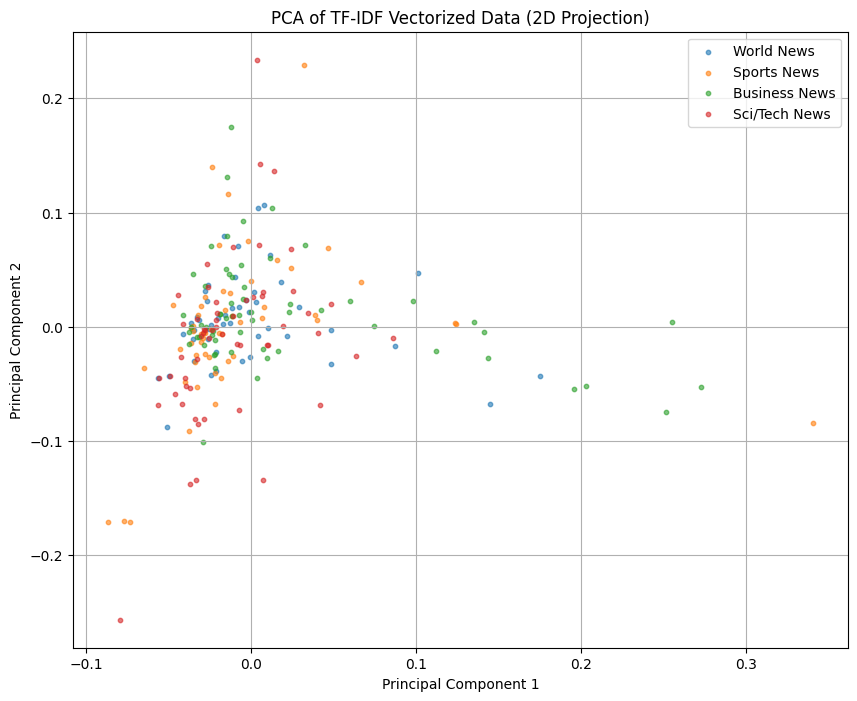

PCA dimensionality reduction and visualization for TF-IDF completed.


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Define a mapping from numerical labels to category names for AG News dataset
label_mapping = {
    0: 'World News',
    1: 'Sports News',
    2: 'Business News',
    3: 'Sci/Tech News'
}

# 2. Define a sample size
sample_size = 5000

# 3. Generate random indices for sampling (for TF-IDF data)
# Ensure X_train_tfidf is not empty before sampling
if X_train_tfidf.shape[0] > 0:
    random_indices_tfidf = np.random.choice(X_train_tfidf.shape[0], size=sample_size, replace=False)
else:
    raise ValueError("X_train_tfidf is empty, cannot sample.")

# 4. Create X_train_tfidf_sampled
X_train_tfidf_sampled = X_train_tfidf[random_indices_tfidf]

# 5. Create y_train_sampled (for TF-IDF data)
y_train_tfidf_sampled = y_train.iloc[random_indices_tfidf]

# 6. Initialize a PCA object with n_components=2
pca_tfidf = PCA(n_components=2)

# 7. Fit the PCA model to X_train_tfidf_sampled and transform it
X_train_tfidf_pca = pca_tfidf.fit_transform(X_train_tfidf_sampled.toarray())

# 8. Create a scatter plot for TF-IDF PCA
plt.figure(figsize=(10, 8))

# Iterate through unique labels for plotting
for label_val in sorted(y_train_tfidf_sampled.unique()):
    # Select data points corresponding to the current label
    indices_for_label = y_train_tfidf_sampled[y_train_tfidf_sampled == label_val].index
    # Map these original indices to the sampled indices to get their position in X_train_tfidf_pca
    sampled_indices_in_pca = np.where(np.isin(random_indices_tfidf, indices_for_label))[0]

    plt.scatter(
        X_train_tfidf_pca[sampled_indices_in_pca, 0],
        X_train_tfidf_pca[sampled_indices_in_pca, 1],
        label=label_mapping.get(label_val, f'Label {label_val}'), # Use mapped label name
        alpha=0.6,
        s=10 # Smaller point size for better visualization with many points
    )

# 9. Add a title to the plot
plt.title('PCA of TF-IDF Vectorized Data (2D Projection)')

# 10. Add x-axis and y-axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 11. Display a legend
plt.legend()

# Add a grid for better readability
plt.grid(True)

# 12. Use plt.show() to display the plot
plt.show()

print("PCA dimensionality reduction and visualization for TF-IDF completed.")

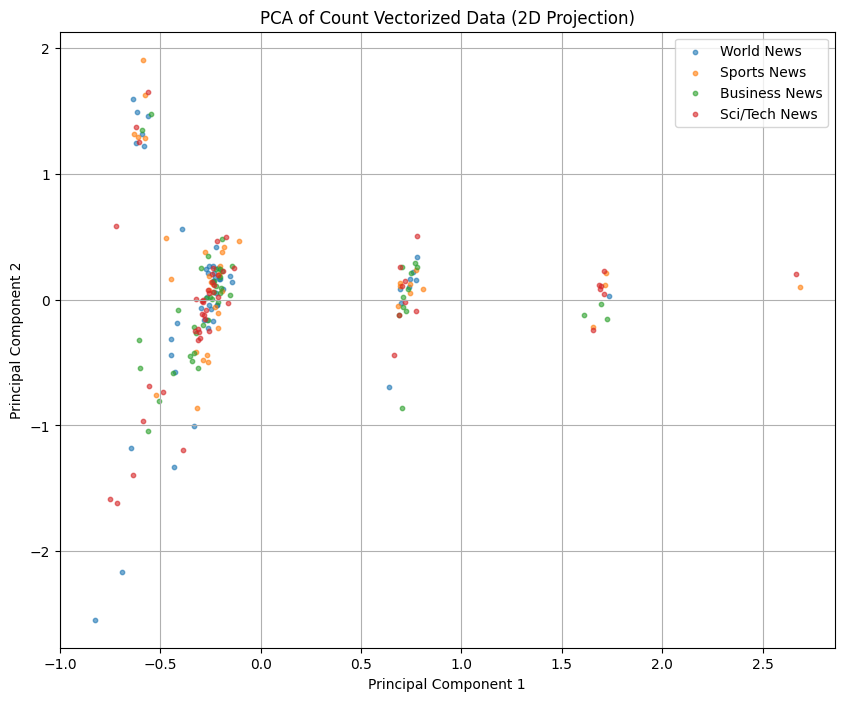

PCA dimensionality reduction and visualization completed.


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Define a mapping from numerical labels to category names for AG News dataset
label_mapping = {
    0: 'World News',
    1: 'Sports News',
    2: 'Business News',
    3: 'Sci/Tech News'
}

# 2. Define a sample size
sample_size = 5000

# 3. Generate random indices for sampling
# Ensure X_train_count is not empty before sampling
if X_train_count.shape[0] > 0:
    random_indices = np.random.choice(X_train_count.shape[0], size=sample_size, replace=False)
else:
    raise ValueError("X_train_count is empty, cannot sample.")

# 4. Create X_train_count_sampled
X_train_count_sampled = X_train_count[random_indices]

# 5. Create y_train_sampled
y_train_sampled = y_train.iloc[random_indices]

# 6. Initialize a PCA object with n_components=2
pca = PCA(n_components=2)

# 7. Fit the PCA model to X_train_count_sampled and transform it
X_train_count_pca = pca.fit_transform(X_train_count_sampled.toarray()) # .toarray() might be needed if it's a sparse matrix

# 8. Create a scatter plot
plt.figure(figsize=(10, 8))

# Iterate through unique labels for plotting
for label_val in sorted(y_train_sampled.unique()):
    # Select data points corresponding to the current label
    indices_for_label = y_train_sampled[y_train_sampled == label_val].index
    # Map these original indices to the sampled indices to get their position in X_train_count_pca
    sampled_indices_in_pca = np.where(np.isin(random_indices, indices_for_label))[0]

    plt.scatter(
        X_train_count_pca[sampled_indices_in_pca, 0],
        X_train_count_pca[sampled_indices_in_pca, 1],
        label=label_mapping.get(label_val, f'Label {label_val}'), # Use mapped label name
        alpha=0.6,
        s=10 # Smaller point size for better visualization with many points
    )

# 9. Add a title to the plot
plt.title('PCA of Count Vectorized Data (2D Projection)')

# 10. Add x-axis and y-axis labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# 11. Display a legend
plt.legend()

# Add a grid for better readability
plt.grid(True)

# 12. Use plt.show() to display the plot
plt.show()

print("PCA dimensionality reduction and visualization completed.")

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression model with specified parameters
# Setting max_iter to 1000 to ensure convergence and solver='liblinear'
# for better performance on potentially smaller datasets or with L1/L2 regularization.
logistic_regression_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

print("Training Logistic Regression model...")
# Train the model using the TF-IDF vectorized training data
logistic_regression_model.fit(X_train_tfidf, y_train)

print("Logistic Regression model trained successfully.")

Training Logistic Regression model...
Logistic Regression model trained successfully.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation set
print("Making predictions on the validation set...")
y_val_pred = logistic_regression_model.predict(X_val_tfidf)
print("Predictions on validation set completed.")

# Make predictions on the test set
print("Making predictions on the test set...")
y_test_pred = logistic_regression_model.predict(X_test_tfidf)
print("Predictions on test set completed.")

Making predictions on the validation set...
Predictions on validation set completed.
Making predictions on the test set...
Predictions on test set completed.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate performance on the validation set
print("\n--- Validation Set Performance ---")
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average='weighted') # Use 'weighted' for multi-class classification
val_recall = recall_score(y_val, y_val_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

# Evaluate performance on the test set
print("\n--- Test Set Performance ---")
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

print("Model evaluation completed for both validation and test sets.")


--- Validation Set Performance ---
Validation Accuracy: 0.9139
Validation Precision: 0.9137
Validation Recall: 0.9139
Validation F1-score: 0.9136

--- Test Set Performance ---
Test Accuracy: 0.9160
Test Precision: 0.9158
Test Recall: 0.9160
Test F1-score: 0.9158
Model evaluation completed for both validation and test sets.


In [ ]:
import collections

def predict_category(text):
    """
    Cleans the input text, vectorizes it, and predicts its news category.

    Args:
        text (str): The input text to classify.

    Returns:
        tuple: A tuple containing the predicted news category name (str) and its numerical label (int).
    """
    # 1. Clean the input text using the already defined clean_text function
    cleaned_input_text = clean_text(text)

    # Handle empty cleaned text
    if not cleaned_input_text:
        return "Could not determine category (empty text)", -1

    # 2. Vectorize the cleaned text using the tfidf_vectorizer object
    # The vectorizer expects an iterable, so wrap the cleaned text in a list.
    vectorized_input = tfidf_vectorizer.transform([cleaned_input_text])

    # 3. Use the trained logistic_regression_model to predict the category
    predicted_label = logistic_regression_model.predict(vectorized_input)[0]

    # 4. Map the numerical label to its corresponding category name
    predicted_category_name = label_mapping.get(predicted_label, "Unknown Category")

    return predicted_category_name, predicted_label

print("Prediction function updated to return both category name and label.")

Prediction function updated to return both category name and label.


In [27]:
import gradio as gr
import collections

# Define a function to be used by Gradio that returns both outputs
def combined_predict_and_count_for_gradio(text_input, current_total_counts_state):
    """
    Processes the input text to provide a primary category prediction,
    and updates/displays accumulated counts of all topics mentioned.
    """
    articles = text_input.strip().split('\n')

    # Initialize counts for the current submission
    current_submission_labels = []

    # Initialize primary_category_name
    primary_category_name = "N/A"
    first_category_set = False

    if not articles or all(not article.strip() for article in articles):
        # Return the state unchanged if no valid input
        return "Please enter some text.", "No topics to count.", current_total_counts_state

    # Process each article for prediction and counting
    for article in articles:
        if article.strip():
            cat_name, label = predict_category(article)

            if not first_category_set: # Get primary category from the first valid article
                primary_category_name = cat_name
                first_category_set = True

            if label != -1:
                current_submission_labels.append(label)

    if not first_category_set:
        primary_category_name = "Could not classify any article."

    # Update accumulated counts
    if current_total_counts_state is None:
        updated_total_counts = collections.Counter()
    else:
        # Convert to Counter if it's not already (Gradio might pass a dict-like object)
        updated_total_counts = collections.Counter(current_total_counts_state)

    updated_total_counts.update(current_submission_labels)

    # Format accumulated counts for display
    if not updated_total_counts:
        topic_counts_string = "No topics identified yet."
    else:
        output_lines = []
        for label, count in sorted(updated_total_counts.items()):
            category_name = label_mapping.get(label, "Unknown Category")
            output_lines.append(f"{category_name}: {count} time(s)")
        topic_counts_string = "\n".join(output_lines)

    return primary_category_name, topic_counts_string, updated_total_counts

# Define the single Gradio interface
combined_interface = gr.Interface(
    fn=combined_predict_and_count_for_gradio,
    inputs=[
        gr.Textbox(lines=10, placeholder="Enter one or more news articles here (one per line)..."),
        gr.State(value=collections.Counter()) # Initialize gr.State with an empty Counter
    ],
    outputs=[
        gr.Label(label="Predicted Category (First Article)"),
        gr.Textbox(lines=5, label="Total News Topic Counts (Accumulated)"),
        gr.State() # Output for the state to be carried over
    ],
    title="News Article Categorizer",
)

# Launch the combined interface
print("Launching combined Gradio interface with persistent topic counts...")
combined_interface.launch(share=True)

Launching combined Gradio interface with persistent topic counts...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9349e5513309dd0e70.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
